In [1]:
import os, cv2, random, shutil
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, LSTM, Dense, TimeDistributed, Flatten, Dropout
from tensorflow.keras.applications import MobileNetV2


2025-05-06 07:58:16.389329: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746518296.601494      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746518296.660232      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
import os
import shutil
import random

# Source path of the UCF101 action recognition dataset
SOURCE_DIR = '/kaggle/input/ucf101-action-recognition/train'
DEST_DIR = '/kaggle/working/UCF101_subset'

# 5 selected classes
SELECTED_CLASSES = ['Basketball', 'Biking', 'PlayingGuitar', 'Typing', 'JumpRope']
VIDEOS_PER_CLASS = 10

os.makedirs(DEST_DIR, exist_ok=True)

for cls in SELECTED_CLASSES:
    class_path = os.path.join(SOURCE_DIR, cls)
    dest_class_path = os.path.join(DEST_DIR, cls)
    os.makedirs(dest_class_path, exist_ok=True)

    all_videos = os.listdir(class_path)
    selected = random.sample(all_videos, VIDEOS_PER_CLASS)

    for video in selected:
        shutil.copy(os.path.join(class_path, video), dest_class_path)

print("Subset created at:", DEST_DIR)


Subset created at: /kaggle/working/UCF101_subset


In [3]:
import cv2
import numpy as np

def extract_frames_from_video(video_path, max_frames=16, resize=(112, 112), frame_skip=5):
    cap = cv2.VideoCapture(video_path)
    frames = []
    count = 0
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        if count % frame_skip == 0:
            frame = cv2.resize(frame, resize)
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frames.append(frame)
        count += 1
        if len(frames) >= max_frames:
            break
    cap.release()

    # Pad if less than 16 frames
    while len(frames) < max_frames:
        frames.append(frames[-1])  # Repeat last frame

    return np.array(frames)


In [4]:
import os
from tqdm import tqdm

DATASET_PATH = '/kaggle/working/UCF101_subset'
X = []
y = []

class_names = sorted(os.listdir(DATASET_PATH))
label_map = {label: idx for idx, label in enumerate(class_names)}

for cls in class_names:
    class_path = os.path.join(DATASET_PATH, cls)
    for video_file in tqdm(os.listdir(class_path), desc=f'Loading {cls}'):
        video_path = os.path.join(class_path, video_file)
        frames = extract_frames_from_video(video_path)  # shape: (16, 112, 112, 3)
        X.append(frames)
        y.append(label_map[cls])

X = np.array(X)  # shape: (num_samples, 16, 112, 112, 3)
y = np.array(y)


Loading Typing: 100%|██████████| 10/10 [00:00<00:00, 71.68it/s]


In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Flatten, Dense, Dropout

model = Sequential([
    Conv3D(32, kernel_size=(3,3,3), activation='relu', input_shape=(16, 112, 112, 3)),
    MaxPooling3D(pool_size=(2,2,2)),
    Conv3D(64, (3,3,3), activation='relu'),
    MaxPooling3D((2,2,2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(len(class_names), activation='softmax')
])
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1746518482.141461      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1746518482.142253      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [7]:
history = model.fit(X_train, y_train, epochs=30, batch_size=2, validation_data=(X_test, y_test))


Epoch 1/30


I0000 00:00:1746518487.775560     295 service.cc:148] XLA service 0x7e95b000b770 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746518487.776162     295 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1746518487.776181     295 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1746518488.013030     295 cuda_dnn.cc:529] Loaded cuDNN version 90300


13/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.1122 - loss: 414.3924 

I0000 00:00:1746518491.078267     295 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - accuracy: 0.1330 - loss: 323.7181 - val_accuracy: 0.3000 - val_loss: 1.5732
Epoch 2/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.4042 - loss: 1.4912 - val_accuracy: 0.6000 - val_loss: 1.3853
Epoch 3/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5473 - loss: 0.9384 - val_accuracy: 0.1000 - val_loss: 1.5134
Epoch 4/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7721 - loss: 0.8251 - val_accuracy: 0.3000 - val_loss: 1.5348
Epoch 5/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.4315 - loss: 1.2347 - val_accuracy: 0.4000 - val_loss: 1.5563
Epoch 6/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7504 - loss: 1.2862 - val_accuracy: 0.3000 - val_loss: 1.5201
Epoch 7/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6154 - loss: 1.0003 - val_accuracy: 0.6000 - val_loss: 1.5521
Epoch 8/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5834 - loss: 0.8438 - val_accuracy: 0.7000 - val_loss: 

In [8]:
import numpy as np

# Get predicted probabilities
y_pred_probs = model.predict(X_test)

# Convert to predicted class labels
y_pred = np.argmax(y_pred_probs, axis=1)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 964ms/step


In [10]:
from sklearn.metrics import accuracy_score

acc = accuracy_score(y_test, y_pred)
print("Test Accuracy:", acc)


Test Accuracy: 0.5


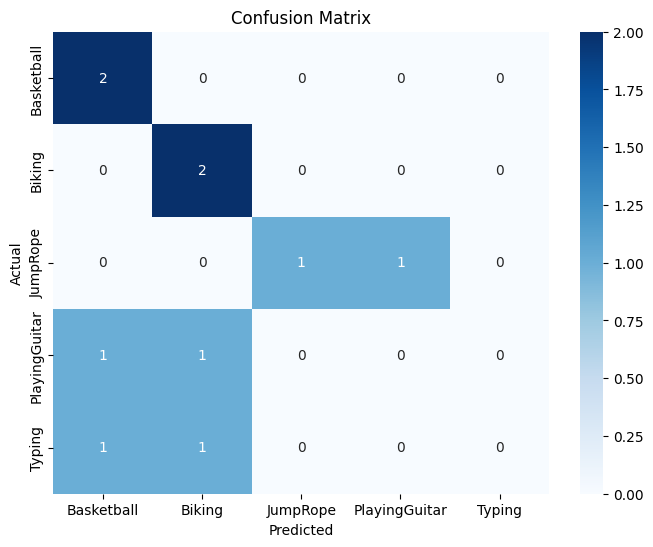

In [11]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [12]:
from sklearn.metrics import classification_report

print("Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=class_names))


Classification Report:

               precision    recall  f1-score   support

   Basketball       0.50      1.00      0.67         2
       Biking       0.50      1.00      0.67         2
     JumpRope       1.00      0.50      0.67         2
PlayingGuitar       0.00      0.00      0.00         2
       Typing       0.00      0.00      0.00         2

     accuracy                           0.50        10
    macro avg       0.40      0.50      0.40        10
 weighted avg       0.40      0.50      0.40        10



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
